# MU4MA077, Base d'analyse de donnée, 2024-2025
# Analyse en Composantes Principales

<div style="text-align: right"> 
Sorbonne Université, Master 1
</div>

<div style="text-align: right"> 
Merci à Catherine Matias, Celine Duval, Alasdair Newson et aux autres collègues dont j'ai pu m'inspirer pour construire ce TP
</div>


# Table of contents
1. [Analyse du jeu de données "notes"](#part1)
    - [Analyse descriptive rapide des notes](#part1sec1)
    - [Analyse en composantes prinsipales des notes](#part1sec2)
    - [Cercle de corrélation en Python](#part1sec3)
    - [Utilisation de sklearn pour faire une ACP](#part1sec4)
2. [Le cas particulier des jeux de données d'images](#part2)
    - [Chargement et première visualisation](#part2sec1)
    - [Premiers pas de traitment d'un jeu de données d'image](#part2sec2)
    - [L'analyse en composantes principales sur un jeu de données d'image](#part2sec3)
    - [Visualisation des points dans le nouveau repère et analyse des nouvelles variables](#part2sec4)
3. [Quelques exercices](#part3)
    - [Exercice 1](#part3sec1)
    - [Exercice 2](#part3sec2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import joblib

# Analyse du jeu de données "notes" <a id="part1"></a>

Pour cette première partie, nous allons tenter de reproduire les exemples du cours en utilisant le jeu de données associé : **notes_ACP.txt**. Ce jeu de données contient les notes de plusieurs étudiants dans quatre matières : Français, Anglais, Mathématiques et Physique.

In [2]:
# Chargement des données
notes = pd.read_csv('notes_ACP.txt', sep=' ')

# Aperçu des données
print(notes)

      MATH  PHYS  FRAN  ANGL
jean   6.0   6.0   5.0   5.5
alan   8.0   8.0   8.0   8.0
anni   6.0   7.0  11.0   9.5
moni  14.5  14.5  15.5  15.0
didi  14.0  14.0  12.0  12.5
andr  11.0  10.0   5.5   7.0
pier   5.5   7.0  14.0  11.5
brig  13.0  12.5   8.5   9.5
evel   9.0   9.5  12.5  12.0


## Analyse descriptive rapide des notes <a id="part1sec1"></a>

Pour commencer nous allons faire une rapide étude statistique du jeu de données. 

<b style="color:red"> À vous de jouer :</b> Pour chaque variable du jeu de données : 
- Calulez le minimum et maximum des valeurs prisent par la variable
- Calulez la moyennne et deviation standard des valeurs prisent par la variable
- Calulez les quartiles (1er ,2eme, 3eme) des valeurs prisent par la variable
- Tracez un violonplot pour chaque variable

Tracez également un pairplot et commentez vos résultats. 

Variable MATH
count     9.000000
mean      9.666667
std       3.579455
min       5.500000
25%       6.000000
50%       9.000000
75%      13.000000
max      14.500000
Name: MATH, dtype: float64

 

Variable PHYS
count     9.000000
mean      9.833333
std       3.172144
min       6.000000
25%       7.000000
50%       9.500000
75%      12.500000
max      14.500000
Name: PHYS, dtype: float64

 

Variable FRAN
count     9.000000
mean     10.222222
std       3.683673
min       5.000000
25%       8.000000
50%      11.000000
75%      12.500000
max      15.500000
Name: FRAN, dtype: float64

 

Variable ANGL
count     9.000000
mean     10.055556
std       2.983752
min       5.500000
25%       8.000000
50%       9.500000
75%      12.000000
max      15.000000
Name: ANGL, dtype: float64

 



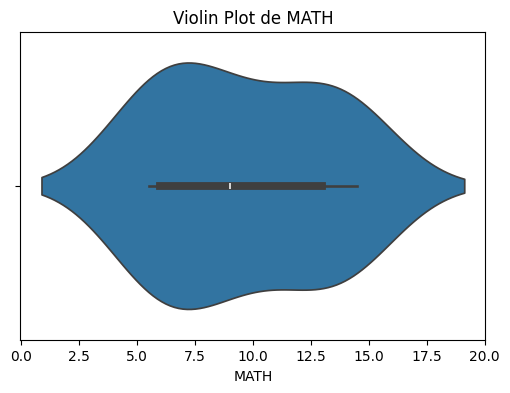

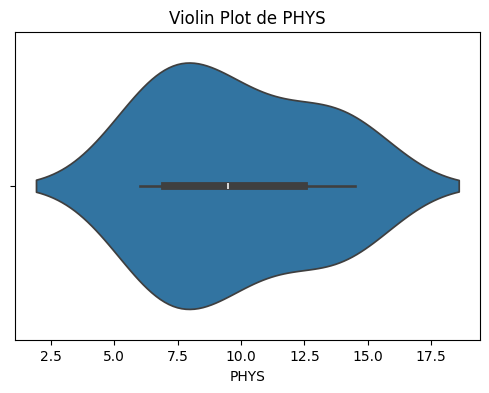

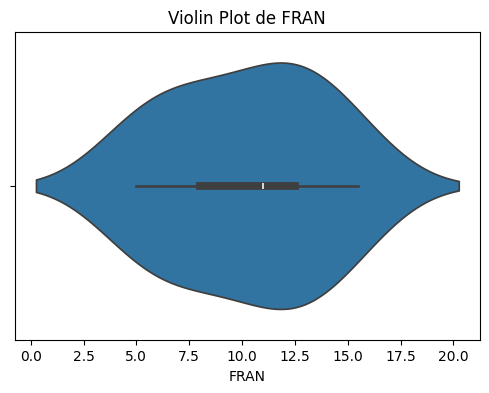

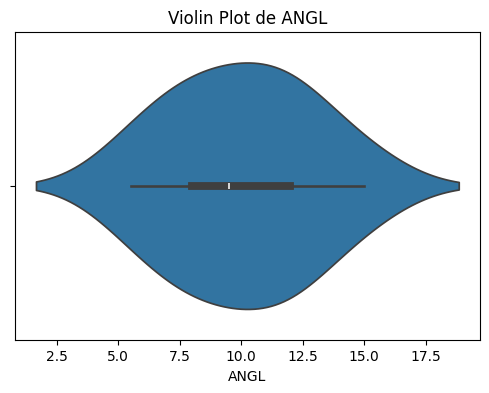

In [3]:
#Reponse
for variable in notes.columns:
    print(f"Variable {variable}")
    print(notes[variable].describe())
    print("\n \n")
    plt.figure(figsize=(6, 4))
    sns.violinplot(x=notes[variable])
    plt.title(f"Violin Plot de {variable}")
    
    

## Analyse en composantes prinsipales des notes <a id="part1sec2"></a>
 
Nous allons à présent suivre les étapes de construction de l'analyse en composantes principales rappelés ci-dessous. 

- On calcule la matrice de variance-covariance des données. Pour rappel, soit un jeu de données $\mathbf{Z} \in \mathbb{R}^{n \times d}$, la matrice de variance-covariance $\textbf{Cov}_{\mathbf{Z}}$ peut se réécrire      comme un produit matriciel
  $$
    \textbf{Cov}_{\mathbf{Z}}= \frac{1}{n} \left( \mathbf{Z} - \mathbf{\bar{Z}} \right)^T \left( \mathbf{Z} - \mathbf{\bar{Z}} \right),
  $$
    avec 
    $\mathbf{\bar{Z}}:= \left( \bar{z}^{(1)} ~\mathbf{1_n}, \dots, \bar{z}^{(d)} ~\mathbf{1_n}  \right) \text{ avec } ~\mathbf{1_n} := (~ \underbrace{1, \dots, 1}_{n \text{ fois} } ~)^T.$
- On calcule les valeurs propres et les vecteurs propres de la matrice de variance-covariance des données (normalisées ou non). 
- On ordonne les valeurs propres par ordre décroissant $\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_d$ (avec les vecteurs propres associés).
  
- Les droites qui ont pour vecteurs directeurs les vecteurs propres $u_1, \dots, u_d$ sont appelées les axes principaux.
  
-  L'inertie expliquée par le $i^{\text{ème}}$ axe est $\lambda_i$, et l'inertie expliquée par le premier plan principal (les deux premiers axes) est $\lambda_1 + \lambda_2$.

Avant tout, n'oublions pas de standardiser les données pour faciliter l'analyse en composantes principales.

In [4]:
# Standardisation des données
scaler = StandardScaler()
notes_scaled = scaler.fit_transform(notes)

#Verification
print(np.var(notes_scaled, axis=0))
print(np.mean(notes_scaled, axis=0)) 

[1. 1. 1. 1.]
[ 1.81953218e-16 -2.20502629e-16  2.34380416e-16  2.46716228e-17]


<b style="color:red"> À vous de jouer :</b> 
- Calculez la matrice de variance-covariance des données (en ecrivant vous même la fonction ou en trouvant une fonction Python adaptée).
- Diagonalisez cette matrice pour obtenir les valeurs propres (inertie expliquée) et les vecteurs propres (axes principaux). Pour cela on pourra utiliser la fonction `linalg.eig` de `numpy`.
- Representez graphiquement par un diagramme en baton la part d'inertie expliquée de chaque axe principal.

Combien d'axes principaux pensez vous qu'il est justifiable de conserver ? 

La mtrice de covariance empirque est :
 [[1.         0.98253573 0.22673193 0.50814398]
 [0.98253573 1.         0.39669324 0.65153051]
 [0.22673193 0.39669324 1.         0.95120575]
 [0.50814398 0.65153051 0.95120575 1.        ]]

Les valeurs propres sont : [2.87569e+00 1.11969e+00 1.05000e-03 3.58000e-03]

Les vecteurs propres sont : [[-0.47845402 -0.55194891  0.65222562  0.20257316]
 [-0.53191716 -0.40680183 -0.59742507 -0.44120255]
 [-0.44393038  0.62123362  0.36542644 -0.53240785]
 [-0.53951061  0.37938563 -0.29008368  0.69343082]]


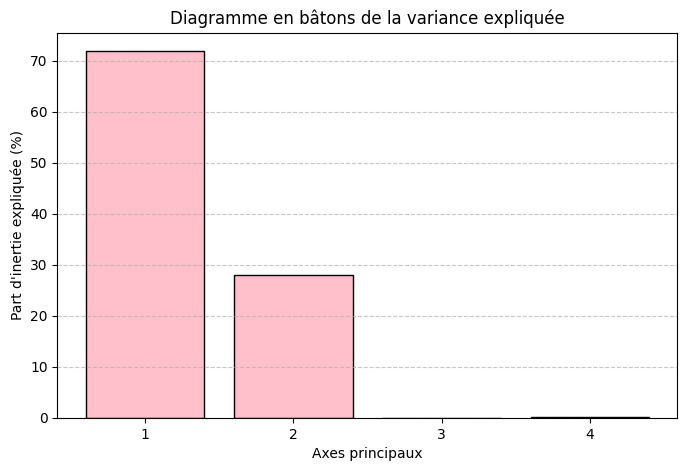

In [5]:
#Reponse
from numpy import linalg as la

n = len(notes_scaled[:,0])
mat_cov = (1/n) * (notes_scaled.T @ notes_scaled)
e_values , e_vectors = la.eig(mat_cov)
e_vectors = np.array(e_vectors)
variance_expliquee = e_values / np.sum(e_values) * 100  

#J'affiche 
print(f"La mtrice de covariance empirque est :\n {mat_cov}")
print(f"\nLes valeurs propres sont : {np.round(e_values, 5)}")
print(f"\nLes vecteurs propres sont : {e_vectors}")

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(e_values) + 1), variance_expliquee, color="pink", edgecolor="black")
plt.xlabel("Axes principaux")
plt.ylabel("Part d'inertie expliquée (%)")
plt.title("Diagramme en bâtons de la variance expliquée")
plt.xticks(range(1, len(e_values) + 1))  
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


<b style="color:red"> Réponse possible :</b> 

On souhaite conserver les deux premiers axes principaux


Les axes principaux donnent les coordonnées des individus dans un nouveau repère. En fait, elles correspondent a de nouvelles variables résumant les anciennes variables. Ils nous permettent également de tracer une nouvelle representation du nuage de point. 

<b style="color:red"> À vous de jouer :</b> Representez le jeu de données dans les nouveau repère (Axe principal 1, Axe principal 2) et (Axe principal 1, Axe principal 3). Pour une meilleur interpretation, on ajoutera le nom de chaque élève à coté du point le représentant. Commentez. 

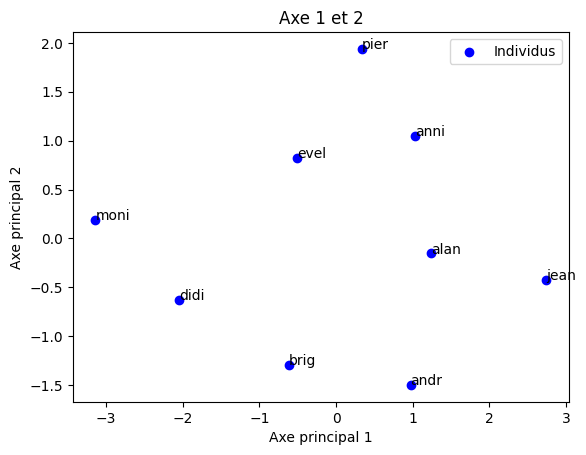

In [6]:
principal_componants = notes_scaled @ e_vectors[:, :3]
nom = notes.index.to_list()


plt.scatter(principal_componants[:, 0], principal_componants[:, 1], color="blue", label="Individus")
plt.xlabel("Axe principal 1")
plt.ylabel("Axe principal 2")
plt.legend()
for i, txt in enumerate(nom):
    plt.annotate(txt, (principal_componants[i, 0], principal_componants[i, 1]))
plt.title("Axe 1 et 2")
plt.show()


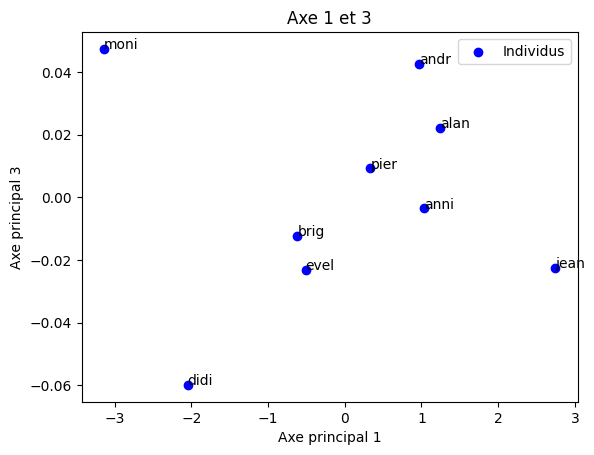

In [7]:
plt.scatter(principal_componants[:, 0], principal_componants[:, 2], color="blue", label="Individus")
plt.xlabel("Axe principal 1")
plt.ylabel("Axe principal 3")
plt.legend()
for i, txt in enumerate(nom):
    plt.annotate(txt, (principal_componants[i, 0], principal_componants[i, 2]))
plt.title("Axe 1 et 3")
plt.show()

## Cercle de corrélation en Python <a id="part1sec3"></a>

On souhaite à présent verifier si la représentation dans le nouveau repère est de bonne qualité. Pour cela, on peut par exemple, tracer un cercle de corrélation. Si dessous, vous trouverez la fonction **plot_correlation_circle** qui vous aidera à faire cette représentation.

<b style="color:red"> À vous de jouer :</b> En utilisant la fonction ci-dessous, tracez le cercle de corrélation pour l'analyse en composantes principales que nous venons de mener. Interpretez. 

In [75]:
def plot_correlation_circle(initial_variables, new_variables, feature_names, pc_labels=['PC1', 'PC2']):
    plt.figure(figsize=(8, 8))
    
    # Tracer un cercle unité
    circle = plt.Circle((0, 0), 1, color='gray', fill=False)
    plt.gca().add_artist(circle)
    
    # Tracer les flèches (correlations des variables)
    for i in range(initial_variables.shape[1]):
        x=np.corrcoef(new_variables[:,0],initial_variables[:,i])[0,1]
        y=np.corrcoef(new_variables[:,1],initial_variables[:,i])[0,1]
        plt.arrow(0, 0, x, y, head_width=0.05, head_length=0.001, fc='red', ec='red')
        plt.text(x * 1.1, y * 1.1, feature_names[i], color='black', ha='center', va='center')
    
    # Ajustements esthétiques
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel(pc_labels[0])
    plt.ylabel(pc_labels[1])
    plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
    plt.title('Cercle de corrélation')
    plt.show()

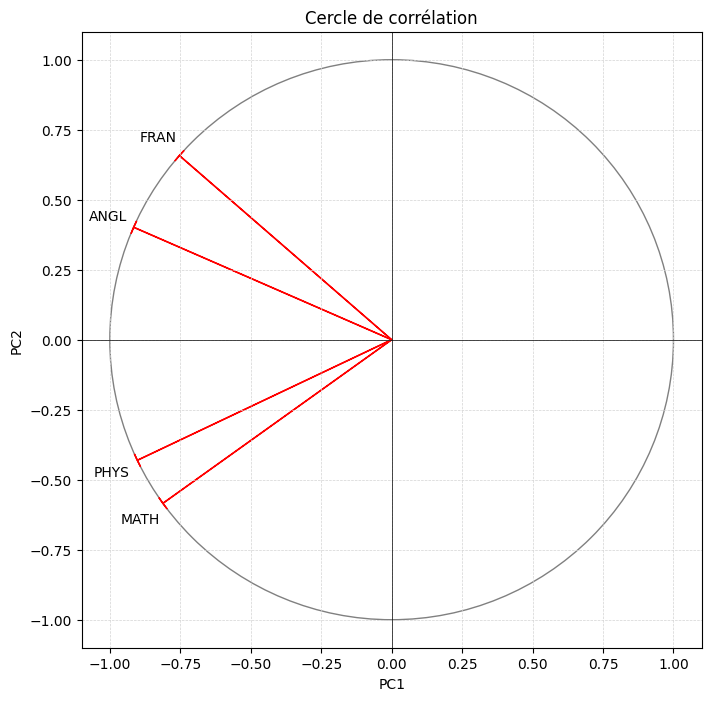

In [76]:
plot_correlation_circle(notes_scaled, principal_componants, notes.columns, pc_labels=['PC1', 'PC2'])

<b style="color:red"> Réponse possible :</b> 

```


## Utilisation de sklearn pour faire une ACP <a id="part1sec4"></a>

Le package ``sklearn`` a un [module](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) dédié à l'ACP. On va donc pouvoir vérifier la qualité de notre implementation. 

<b style="color:red"> À vous de jouer :</b> En utilisant le module que nous venons d'évoquer, relancez l'analyse du jeux de données **notes_scaled** Indication : on pourra utiliser le module PCA. Commentez. 

Indication : utilisation du module PCA : 
```
pca = PCA()
pca_result = pca.fit_transform(notes_scaled)
```

In [78]:
pca = PCA()
pca_result = pca.fit_transform(notes_scaled)
print(pca_result)

[[-2.74282765 -0.42739619  0.02302907 -0.02261728]
 [-1.24063553 -0.15275975  0.00438669  0.02225925]
 [-1.03089425  1.04928798 -0.0582899  -0.00353517]
 [ 3.13812885  0.18561802  0.01140971  0.04737304]
 [ 2.05147076 -0.62781698 -0.02454429 -0.05985174]
 [-0.97094243 -1.49751209  0.02616635  0.0426116 ]
 [-0.33474278  1.93741704 -0.05520073  0.0092521 ]
 [ 0.62017744 -1.29088619 -0.06623779 -0.01239146]
 [ 0.5102656   0.82404816  0.1392809  -0.02310034]]


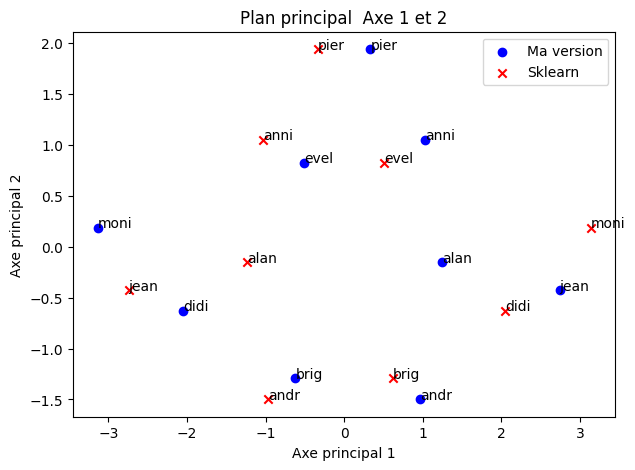

In [79]:
#MA verison
plt.figure(figsize=(7, 5))
plt.xlabel("Axe principal 1")
plt.ylabel("Axe principal 2")

#Ma version
plt.scatter(principal_componants[:, 0], principal_componants[:, 1], color="blue", label="Ma version")
for i, txt in enumerate(nom):
    plt.annotate(txt, (principal_componants[i, 0], principal_componants[i, 1]))

#Skeleran
plt.scatter(pca_result[:, 0], pca_result[:, 1], color="red", marker= 'x', label="Sklearn")
for i, txt in enumerate(nom):
    plt.annotate(txt, (pca_result[i, 0], pca_result[i, 1]))
plt.title("Plan principal  Axe 1 et 2")

plt.legend()
plt.show()


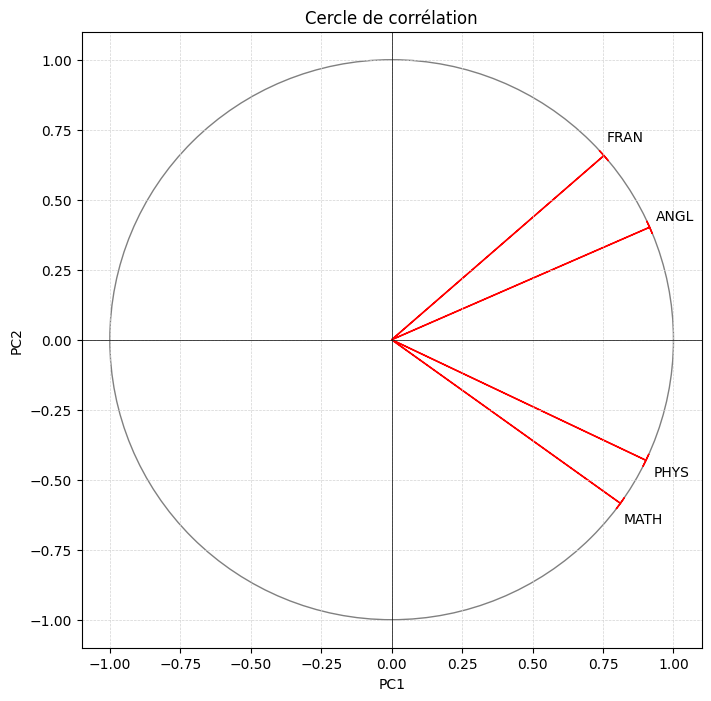

In [80]:
plot_correlation_circle(notes_scaled, pca_result, notes.columns, pc_labels=['PC1', 'PC2'])

<b style="color:red"> Réponse possible :</b>  Il peut y avoir des changements de signe ou des effets d'échelle sur les axes, car les vecteurs propres sont définis à un scalaire près, mais sinon tout devrait être similaire. 


```


# Le cas particulier des jeux de données d'images <a id="part2"></a>

Un exemple caractéristique de données en haute dimension est constitué par les images. Une image est représentée sous forme d’un tableau de nombres positifs. Chaque élément de ce tableau est appelé un "pixel" (en général, ce sont des entiers compris entre 0 et 255). Par exemple, une image standard contenant $(512,512)$ pixels correspond à un vecteur de taille $512 \times 512 = 262,144$, ce qui est très grand et peut poser un certain nombre de difficultés. Cependant, il est nécessaire de traiter des images en apprentissage automatique. Voyons comment l'ACP peut nous aider.

## Chargement et première visualisation <a id="part2sec1"></a>

Pour cela, nous allons étudier un jeu de données très connu, nommé MNIST (pour Modified National Institute of Standards and Technology). Ce jeu de données contient 60,000 images. Chaque image est constituée de 784 pixels organisés dans un carré de taille $28 \times 28$, représentant des chiffres manuscrits de "0" à "9". Chaque pixel encode un niveau de gris compris entre 0 et 255. Bien que ce jeu de données inclue tous les chiffres de "0" à "9", par souci de simplicité, nous nous concentrerons uniquement sur deux chiffres : "0" et "1".

Dans un premier temps, nous allons télécharger les données. Pour ce faire deux options: 

- Télécharger directement MNIST en utilisant la fonction `fetch_openml` de `sklearn`.
- Si la première option ne fonctionne pas, vous pouvez charger le jeu de données sauvegardé au format pkl en utilisant `joblib`

In [20]:
# Option 1: Telecharger directement MNIST
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X = mnist.data.astype(np.float64)  # Features
y = mnist.target.astype(np.int32)  # Labels

# Change it to binary
X=X.loc[y < 2 ,:]
y=y[y < 2]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (14780, 784)
Shape of y: (14780,)


Quelque soit l'option que vous avez choisi, vous pouvez utiliser le morceau de code ci-dessous pour visualiser les deux premières images du jeu de données. Ce code utilise la fonction `imshow` de `matplotlib`. N'hesitez pas à aller voir plus en détail comment representer des images en matplotlib [ici](https://matplotlib.org/stable/tutorials/images.html). 

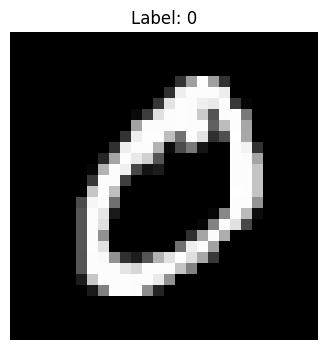

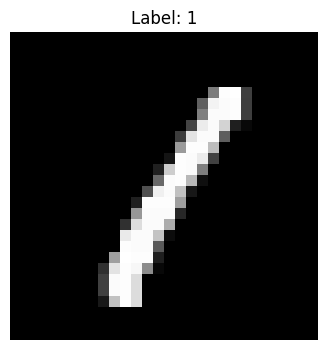

In [23]:
# Visualisation de MNIST
plt.figure(figsize=(4, 4))
plt.imshow(X.values[0, :].reshape(28, 28), cmap='gray')
plt.title(f"Label: {y.values[0]}")
plt.axis('off')
plt.show()

plt.figure(figsize=(4, 4))
plt.imshow(X.values[1, :].reshape(28, 28), cmap='gray')
plt.title(f"Label: {y.values[1]}")
plt.axis('off')
plt.show()

## Premiers pas de traitment d'un jeu de données d'image <a id="part2sec2"></a>

Pour commencer le traitement du jeu de données MNIST, on pourrait essayer de calculer les mêmes statistiques sur **X** que celles que nous avions calculées pour l’analyse du jeu de données **notes** de la section précédente. La méthode `.describe()` nous permet de lancer ces calculs en une seule commande. Voici ce qu’on obtient :

In [24]:
# Statistiques descriptives
print(X.describe())

        pixel1   pixel2   pixel3   pixel4   pixel5   pixel6   pixel7   pixel8  \
count  14780.0  14780.0  14780.0  14780.0  14780.0  14780.0  14780.0  14780.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel9  pixel10  ...  pixel775  pixel776  pixel777  pixel778  \
count  14780.0  14780.0  ...   14780.0   14780.0   14780.0   14780.0   
mean       0.0      0.0  ...       0.0       0.0       0.0       0.0   
std        0.0      0.0  ...       0.0       0.0      

<b style="color:red"> À vous de jouer :</b> Que peut-on dire de tout cela? 

<b style="color:red"> Réponse possible :</b> 

Les colonnes affichée par describe sont toute à 0, en effet pour toutes nos images (0 opu 1) les bords de l'image sont noirs

## L'analyse en composantes principales sur un jeu de données d'image <a id="part2sec3"></a>

On va à présent lancer une analyse en composantes principales sur la composante **X** de notre jeu de données et utiliser la composante **y** pour l’interprétation.

<b style="color:red"> À vous de jouer :</b> En utilisant les fonctions dédiées de `sklearn` :

- Normalisez la matrice **X**.
- Faites une ACP sur **X** en conservant toutes les dimensions (on nommera **F** le nuage de points projetés comme dans le cours).
- Représentez graphiquement par un diagramme en bâton la part d’inertie expliquée par chaque axe principal.

Combien d’axes pensez-vous qu’il faille garder pour avoir une bonne représentation du jeu de données en utilisant le moins d’axes possibles ?

<b style="color:red"> Réponse possible :</b> 
```


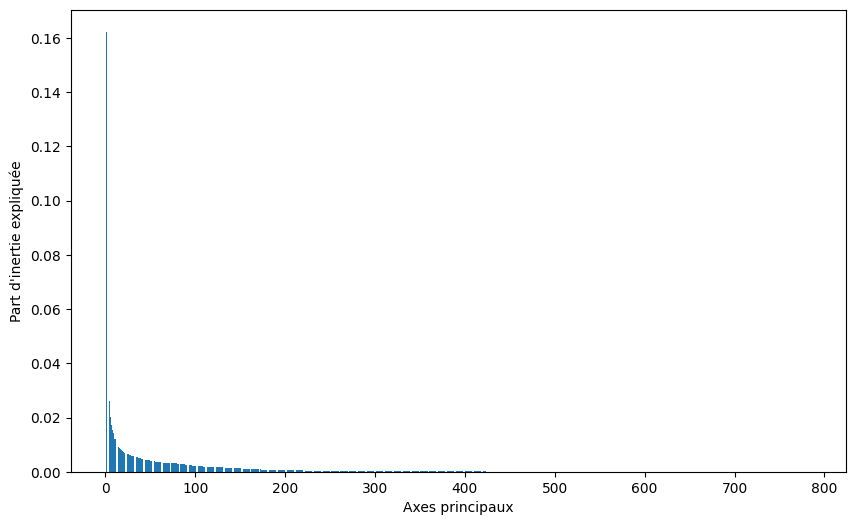

In [62]:
#Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réalisation de l'ACP avec sklearn
pca = PCA()
pca_result = pca.fit_transform(X_scaled)
F= pca_result
plt.figure(figsize=(10, 6))
plt.bar(range(1,len(pca.explained_variance_)+1), pca.explained_variance_  / pca.explained_variance_.sum())
plt.xlabel('Axes principaux')
plt.ylabel('Part d\'inertie expliquée')
plt.show()

<b style="color:red"> Réponse possible (fin) :</b> 

#Réponse

En gardant seulement les 10 premières CP nous garderions une grande part d'information tout en réduisant drastiquement la taille des données. En en conversant 200, nous aurions presque toute l'information

Faire le bon choix du nombre de variables à conserver est souvent compliqué et va dépendre de la méthode que l’on souhaite préconiser. Vous pouvez lire le chapitre ['choix de dimension'](https://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-m-explo-acp) de la plateforme Wikistat pour plus d'information. 




## Visualisation des points dans le nouveau repère et analyse des nouvelles variables <a id="part2sec4"></a>

Pour la suite, on va se concentrer sur les deux premiers axes principaux pour faciliter l’interprétation. Dans un premier temps, nous allons tracer le nuage de points projeté dans le repère (Axe 1, Axe 2). Vous trouverez ci-dessous le morceau de code à exécuter pour cela. Chaque point de la matrice **X** est représenté dans le nouveau repère, et les couleurs correspondent à ce que représente l'image : soit un **0** pour le rouge, soit un **1** pour le bleu.

### Visualisation du nouveau nuage de points


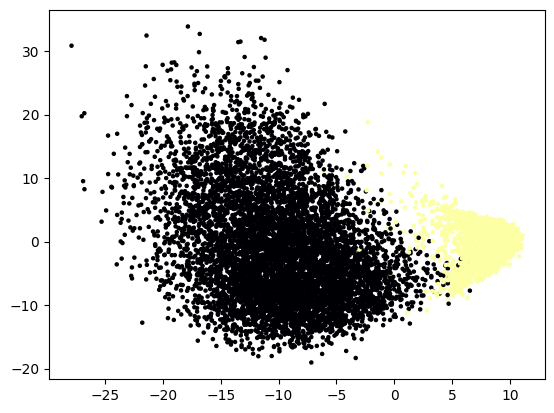

In [32]:
CP1 = pca_result[:, 0]
CP2 = pca_result[:, 1]

plt.scatter(CP1, CP2, c=y, cmap='inferno', s=5)

<b style="color:red"> À vous de jouer :</b> Que peut on dire en observant ce nuage de point ? 

<b style="color:red"> Réponse possible (fin) :</b> 

À première vue, le premier axe principal suffit à séparer les données entre les images représentant **1** en bleu et celles représentant **0** en rouge. En effet, le signe des valeurs prises par le premier axe semble discriminer les images **0** et **1**. Le second axe est peut-être un peu moins pertinent. 

### Visualisation des nouvelles variables 

Rappelez-vous que nous avions initialement 784 variables dans notre ensemble de données (une par pixel). Pensez-vous qu'il soit vraiment pertinent de dessiner un cercle de corrélation ? **Spoiler alert:** Non, on ne verrait rien. En revanche, le premier axe principal semble particulièrement intéressant et pertinent pour discriminer les différentes images. Notons que cet axe est un vecteur de taille $784$, nous pouvons donc le représenter comme une image carrée de $28 \times 28$ pixels. C'est ce que nous allons faire : 

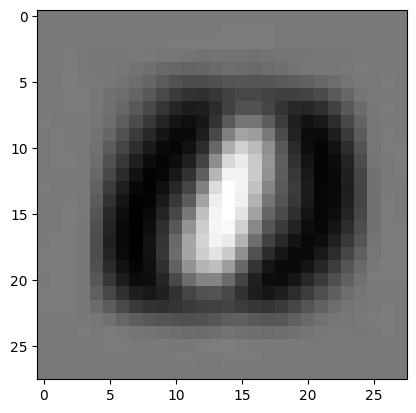

In [26]:
Coeff = pca.components_
plt.figure()
plt.imshow(Coeff [0, :].reshape(28, 28), cmap='gray')

<b style="color:red"> À vous de jouer :</b> Sachant que nous venons de représenter le premier axe principal de l'analyse en composantes principales, comment pensez-vous que l'on puisse interpréter cette image ? 

<b style="color:red"> Réponse possible :</b> Il semblerait qu'il y ait un **0** blanc superposé à un **1** noir. Cela signifie que les valeurs prises par cette variable peuvent être interprétées comme une combinaison linéaire d'une image caractérisante **0** et d'une image caractérisante **1** (avec une oposition de signe). Cela semble confirmer (au moins visuellement) que le premier axe oppose des images **0** et **1**. 

# Quelques exercices  <a id="part3"></a>

## Exercice 1  <a id="part3sec1"></a>

On va analyser le jeu de donnée `ozone.csv`, disponible sur moodle, qui contient $n = 112$ observations journalières. On rappelle que sur ce jeu de données, il y a deux variables qualitatives :

- vent : variable qualitative sens du vent (est, nord, sur, ouest)
- pluie : variable qualitative indiquant si temps pluvieux ou sec. On ne prend pas en compte ces variables dans l'ACP.

1. Sur le jeu de données Ozone, en ne gardant que les $n = 20$ premières observations pour commencer, lancez une ACP sur les variables quantitatives (donc sans les variables observations, pluie et vent) et interprétez les résultats. Vous pouvez par exemple répondre aux questions suivantes :

- Commentez le cercle de corrélation : les variables sont elles bien ou mal représentées, les corrélations entre variables, la signification des deux premiers axes.

- Représentation des individus : que penser de la mesure n°11 ? Donner deux mesures pour lesquelles les conditions météo étaient semblables ? Donner une mesure correspondant à une journée très chaude avec une forte concentration d'ozone ? avec un fort vent d'est ?

2. Comment pensez vous que l'on puisse prendre un compte les varaiables vent et pluie ? Vous pouvez lire [ceci](http://wikistat.fr/pdf/st-m-explo-afc.pdf) pour vous faire une idée

In [81]:
#EXERCICE 1

#Chargement des données
ozone = pd.read_csv('ozone.csv', sep=';')

#Prendre les données qui nous interessent
n = 20
ozone = ozone.iloc[:n, : -2]

# Remplacer les virgules par des points et convertir en float
ozone = ozone.replace(',', '.', regex=True).astype(float)

#Standardisation
scaler = StandardScaler()
ozone_scaled = scaler.fit_transform(ozone)

ozone.shape 

(20, 12)

In [ ]:
pca = PCA()
pca_result = pca.fit_transform(ozone)

print(pca_result.shape)

(20, 12)


<BarContainer object of 12 artists>

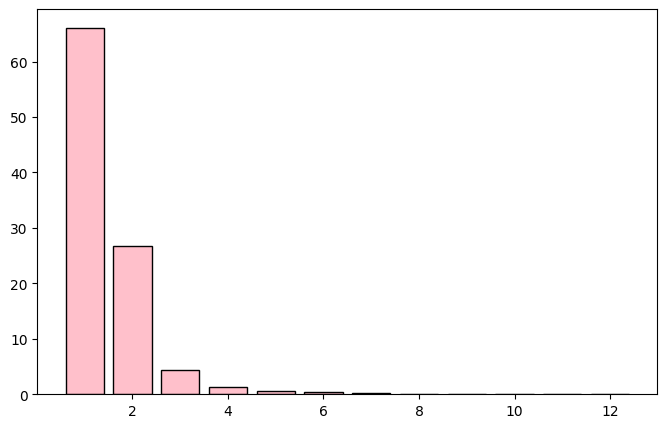

In [83]:
#Variance expliquée
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_ratio_ * 100, color="pink", edgecolor="black")

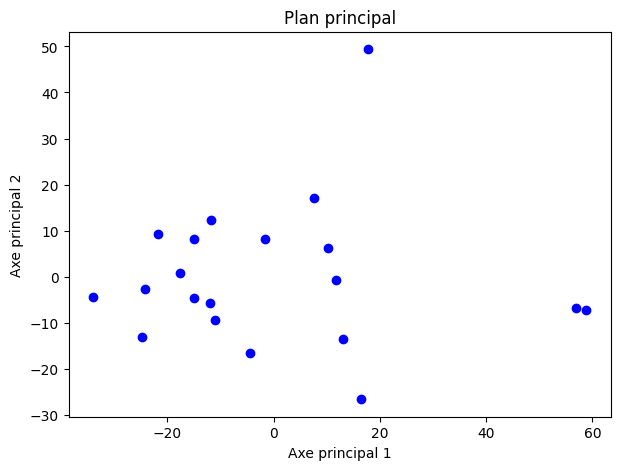

In [84]:
#Plan principal
plt.figure(figsize=(7, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], color="blue")
plt.xlabel("Axe principal 1")
plt.ylabel("Axe principal 2")
plt.title("Plan principal")
plt.show()

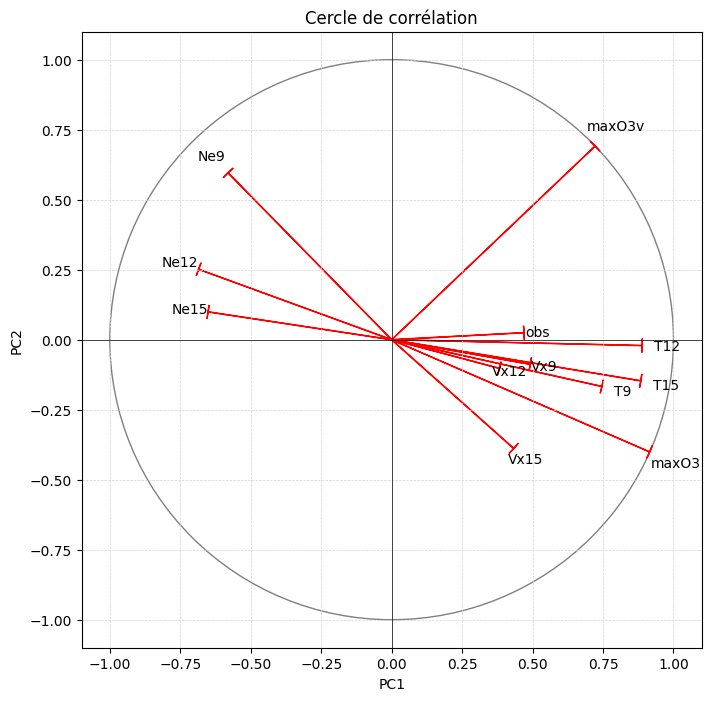

In [85]:
#Cercle de corrélation
plot_correlation_circle(ozone_scaled, pca_result, ozone.columns, pc_labels=['PC1', 'PC2'])

## Exercice 2 <a id="part3sec2"></a>

Nous allons à présent étudier des données données issues de l’observatoire de l’OCDE. Pour chaque pays membre et pour chacune des années 1975, 1977, 1979 et 1981, nous connaissons les valeurs prises par les variables suivantes :

- NATA : taux brut de natalité,
- CHOM : taux de chômage,
- APRI : pourcentage d’actifs dans le secteur primaire,
- ASEC : pourcentage d’actifs dans le secteur secondaire,
- PIB : produit intérieur brut (par habitant),
- FBCF : formation brute de capital fixe (par habitant),
- INFL : hausse des prix,
- RECC : recettes courantes (par habitant),
- MINF : mortalité infantile,
- PROT : consommation de protéines animales (par habitant),
- NRJ : consommation d’énergie (par habitant).

Pour récupérer ces données, chargez le fichier `data_OCDE.csv`. La première colonne contient les initiales du pays concerné et les colonnes suivantes contiennent les $d = 11$ variables.

1. Après une inspection de ces données, décidez de les normaliser ou non et procédez à l’ACP.
2. Étudiez le nombre d’axes à retenir, la qualité de la représentation des points dans les nouveaux axes
3. Dans le plan principal, représentez les n = 68 points relatifs aux 17 pays considérés. Mettre
en évidence les groupes de 4 points correspondants à chaque pays et les relier entre eux de façon
à visualiser le "sens de variation" de chaque pays dans le plan principal. A l’aide de votre étude
préliminaire, interprétez ce graphique. 

In [120]:
#EXERCICE 2

#Chargement des données
data = pd.read_csv('data_OCDE.csv', sep=',')
data.head()

#Enlever la colonne pays du dataset
pays = data['Country']
pays_unique = pays.unique()
data = data.drop(columns='Country')

#Standardisation
data_scaled = scaler.fit_transform(data)

In [113]:
#ACP
pca_result = pca.fit_transform(data_scaled)

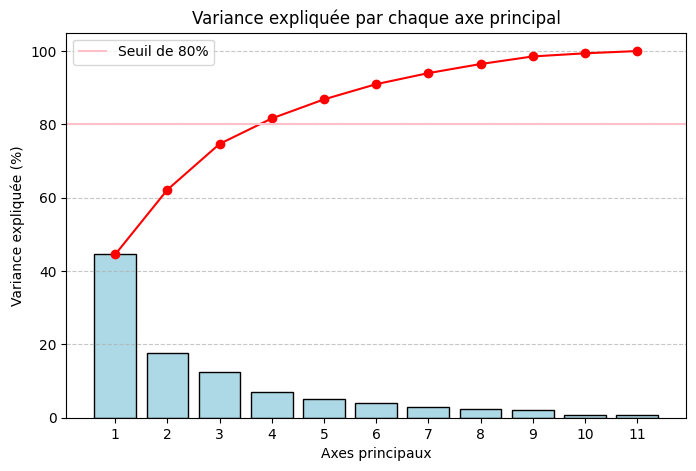

In [114]:
#Variance expliquée
explained_variance = pca.explained_variance_ratio_ * 100
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color="lightblue", edgecolor="black")
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='red')
plt.xlabel("Axes principaux")
plt.ylabel("Variance expliquée (%)")
plt.title("Variance expliquée par chaque axe principal")
plt.xticks(range(1, len(explained_variance) + 1))
plt.axhline(y=80, color='pink', linestyle='-', label="Seuil de 80%")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

C:\Users\tapri\AppData\Local\Temp\ipykernel_20228\2042399222.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(pays_unique))


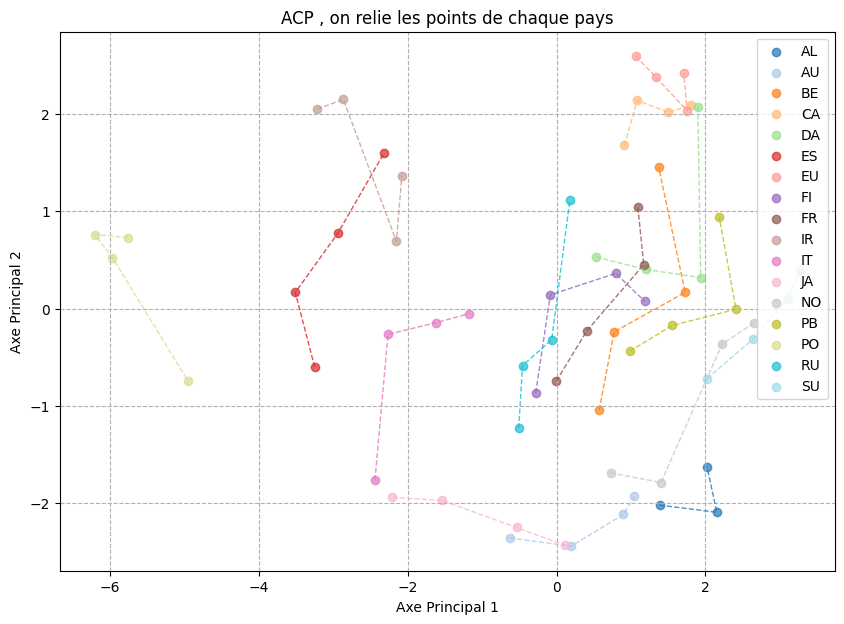

In [139]:
PC1, PC2 = pca_result[:, 0], pca_result[:, 1]
colors = plt.cm.get_cmap("tab20", len(pays_unique))

plt.figure(figsize=(10, 7))

for i, country in enumerate(pays_unique):
    #Filtrer les points du pays i
    indices = (pays == country)
    plt.scatter(PC1[indices], PC2[indices],color=colors(i), label=country,  alpha=0.7)
    

    #On Relie les 4 points de chaque pays
    plt.plot(PC1[indices], PC2[indices],  linestyle="--",color=colors(i), linewidth=1, alpha=0.8)


plt.xlabel("Axe Principal 1")
plt.ylabel("Axe Principal 2")
plt.title("ACP , on relie les points de chaque pays")
plt.legend()
plt.grid(True, linestyle='--')
plt.show()


Pays = AL et i = 0
Pays = AU et i = 1
Pays = BE et i = 2
Pays = CA et i = 3
Pays = DA et i = 4
Pays = ES et i = 5
Pays = EU et i = 6
Pays = FI et i = 7
Pays = FR et i = 8
Pays = IR et i = 9
Pays = IT et i = 10
Pays = JA et i = 11
Pays = NO et i = 12
Pays = PB et i = 13
Pays = PO et i = 14
Pays = RU et i = 15
Pays = SU et i = 16
